# COMPAS Case Study: Fairness of a Machine Learning Model

Reconstructed from Farhan Rahman's work at https://towardsdatascience.com/compas-case-study-fairness-of-a-machine-learning-model-f0f804108751

The above analysis was based on orginal wotk by ProPublica: 
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Additional material included is from *The Alignment Problem* by Brian Christian.

## The use of evidence in parole decisions

*"Our law punishes people for what they do, not who they are. Dispensing punishment on the basis of an immutable characteristic flatly contravenes this guiding principle"*, US Supreme Court Chief Justice John Roberts.

In 1927, the new chairman of the Parole Board of Illinois, Hinton Clabaugh, commissioned a study on the workings of the parole system in the state. He was particularly interested in whether the right people for parole could be selected - those who would not commit further crime. On reviewing evidence, he concluded that certain characteristics, such as having served less than a year, or coming from a farming background, were associated with a lower probability of re-offending. Meanwhile other characteristics, such as those "living in the criminal underworld" were associated with a higher probability of re-offending. He recommended that the Parole Board be given a summary sheet for each man to be paroled which would list key attributes of the person and their association with re-offense rates. By 1951 a *'Manual of Parole Prediction'* had been written for Illinois, outlining the evidence gathered. At the end of the book is a present section on *'Scoring by Machine Methods'*, which considers use of punch-card machines to automate processing of data and outputting individualized prediction of likelihood to re-offend. 

Update of such methods was, however, slow. By 1970 only two states in the US used predictive modeling in parole decisions.But that was to change with the development, in 1998, of *'Correctional Offender Management Profiling for Alternative Sanctions'*, or *'COMPAS'*.

## About COMPAS

COMPAS, an acronym for *Correctional Offender Management Profiling for Alternative Sanctions*, is an assistive software and support tool used to predict recidivism risk, that is the risk that a criminal defendant will re-offend.  

* COMPAS is helpful in ways that it provides scores from 1 (being lowest risk) to 10 (being highest risk).

* It also provides a category based evaluation labeled as high risk of recidivism, medium risk of recidivism, or low risk of recidivism. For simplifying things we can convert this multi-class classification problem into binary classification combining the medium risk and high risk of recidivism vs. low risk of recidivism.

* The input used for prediction of recidivism is wide-scale and uses 137 factors including age, gender, and criminal history of the defendant as the input. COMPAS **does not** use race as an input.

* Race is not an explicit feature considered by the model.

## Use of COMPAS, and the bias uncovered by ProPublica

COMPAS has been used by the U.S. states of New York, Wisconsin, California, Florida’s Broward County, and other jurisdictions. Depending on the scores generated by this software, the judge can decide upon whether to detain the defendant prior to trial and/or when sentencing. It has been observed that the Defendants who are classified medium or high risk (scores of 5–10), are more likely to be held in prison while awaiting trial than those classified as low risk (scores of 1–4). Although this software might seem to be assistive and helpful but it suffers from machine bias. According to an investigative journal ProPublica:

* Though the accuracy is similar for white and black people, the prediction fails differently for the black defendants:

|                                           | White | African-American |
|-------------------------------------------|-------|------------------|
| Labelled high risk, but did not re-offend | 24%   | 45%              |
| Labelled lower risk, but did re-offend    | 48%   | 28%              |

* Overall, COMPAS correctly predicts recidivism 61 percent of the time. But black people are almost twice as likely as white people to be labeled a higher risk but not actually re-offend. It makes the opposite mistake among white people: They are much more likely than black people to be labeled lower risk but go on to commit other crimes. This a major risk of machine learning models might possess and when it comes to someone’s freedom it’s a flaw that shouldn’t go unnoticed.

To get what ProPublica claimed let’s try to make our own model which replicates their analysis.

## Formulating ProPublica analysis

Before starting any analysis, we need to have the proper tools for that — importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Read in the data

After importing the libraries we need to import the data and to know how the data looks like use the following code to visualize it.

Data may be read from local file, or from the internet.

In [2]:
read_local = False

if read_local:
    df = pd.read_csv('compas_data.csv')

else:
    url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
    df = pd.read_csv(url)
    df.to_csv('compas_data.csv')

df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


As stated earlier to make this into a binary classification problem we carry out the following section.

### Transform into a binary classification problem

First, let’s make this a binary classification problem. We will add a new column that translates the risk score (decile_score) into a binary label.
Any score 5 or higher (Medium or High risk) means that a defendant is treated as a likely recividist, and a score of 4 or lower (Low risk) means that a defendant is treated as unlikely to re-offend. As we know that creating a new feature with the help of the existing one might help us to envision data that might go unexplored. The code to do the same is given below:

In [3]:
# turn into a binary classification problem
# create feature is_med_or_high_risk
df['is_med_or_high_risk']  = (df['decile_score']>=5).astype(int)

In [4]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,is_med_or_high_risk
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,1
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0


### Evaluate model performance
To evaluate the performance of the model, we will compare the model’s predictions to the “truth”:

* The risk score prediction of the COMPAS system is in the `decile_score` column,

* The classification of COMPAS as medium/high risk or low risk is in the `is_med_or_high_risk` column

* The “true” recidivism value (whether or not the defendant committed another crime in the next two years) is in the `two_year_recid` column.

### Accuracy

Let’s start by computing the accuracy, and the overall recidivism rate.

In [5]:
# classification accuracy
accuracy = np.mean(df['is_med_or_high_risk']==df['two_year_recid'])
print (f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.654


In [6]:
# Two year recidivism rate
recidivism = np.mean(df['two_year_recid'])
print (f'Recidivism: {recidivism:0.3f}')

Recidivism: 0.451


This, itself, might already be considered problematic…

The accuracy score includes both kinds of errors:

* false positives (defendant is predicted as medium/high risk but does not re-offend)

* false negatives (defendant is predicted as low risk, but does re-offend)

but these errors have different costs. It can be useful to pull them out separately, to see the rate of different types of errors.

## Confusion matrices, false positives, and false negatives

If we create a confusion matrix, we can use it to derive a whole set of classifier metrics:

* True Positive Rate (TPR) also called recall or sensitivity
* True Negative Rate (TNR) also called specificity
* Positive Predictive Value (PPV) also called precision
* Negative Predictive Value (NPV)
* False Positive Rate (FPR)
* False Discovery Rate (FDR)
* False Negative Rate (FNR)
* False Omission Rate (FOR)

Lets plot a confusion matrix of predicted vs. actual:

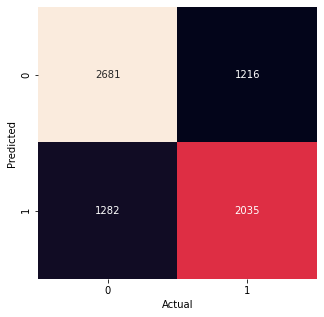

In [7]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'])
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

We can also use `sklearn`'s `confusion_matrix` to pull out these values and compute any metrics of interest:

In [8]:
[[tn , fp],[fn , tp]]  = confusion_matrix(df['two_year_recid'], df['is_med_or_high_risk'])
print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)

True negatives:   2681
False positives:  1282
False negatives:  1216
True positives:   2035


We can replot our confusion matrices, normalising by row or column.

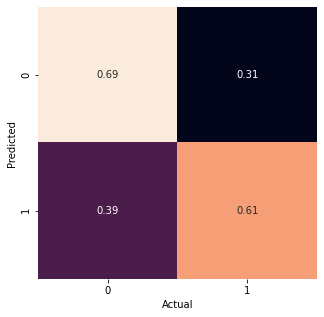

In [9]:
# Normlaise by row
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='index')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

When we normalise by row we can more readily see what happened to our 'predicted' groups. We can see that for those predicted not to re-offend, 69% did not re-offend, and 31% did. For those predicted to re-offend, 61% did re-offend, and 39% did not.

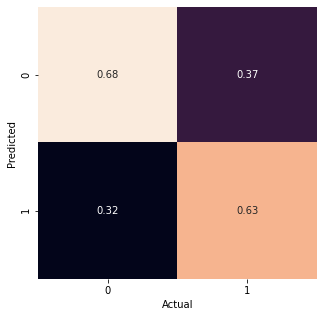

In [10]:
# Normalise by column
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

When we normalise by column we can more readily see what predictions were made for the groups that did or did not re-offend. We can see that of those that did not re-offend, 68% were predicted not to re-offend, whereas 32% were predicted to offend. Of those who went on to re-offend, 63% were predicted to re-offend, whereas 37% were predicted not to re-offend.

If we show false positive rate and false negative rate, we see that a defendant has a similar likelihood of being wrongly labeled a likely recidivist and of being wrongly labeled as unlikely to re-offend.

In [11]:
fpr = fp/(fp+tn)
fnr  = fn/(fn+tp)

print(f'False positive rate (overall): {fpr:0.3f}')
print(f'False negative rate (overall): {fnr:0.3f}')

False positive rate (overall): 0.323
False negative rate (overall): 0.374


### Analyse risk score

We can also directly evaluate the risk score, instead of just the labels. The risk score is meant to indicate the probability that a defendant will re-offend.

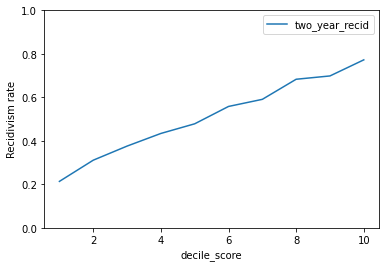

In [12]:
d = df.groupby('decile_score').agg({'two_year_recid': 'mean'})
# plot
sns.lineplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate');

Defendants with a higher COMPAS score indeed had higher rates of recidivism.

### Receiver-Operator Characteristic curve

We can plot a receiver-operator characteristic curve, and calculate area under curve.

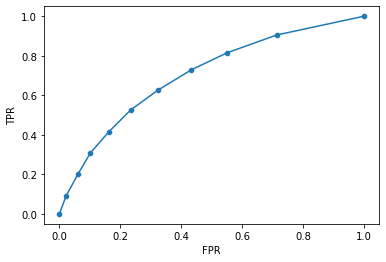

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr);
plt.ylabel("TPR");
plt.xlabel("FPR");

In [14]:
auc = roc_auc_score(df['two_year_recid'], df['decile_score'])
print (f'ROC AUC: {auc:0.3}')

ROC AUC: 0.702


## Fairness

COMPAS has been under scrutiny for issues related for fairness with respect to race of the defendant.

Race is not an explicit input to COMPAS, but some of the questions that are used as input may have strong correlations with race. When we use inputs that correlate with race, race becomes a *redundant variable* - removing it will change little.

First, we will find out how frequently each race is represented in the data (this is recorded, but not used in the COMPAS algorithm):

In [15]:
df['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

We will focus specifically on African-American or Caucasian defendants, since they are the subject of the ProPublica claim.

### Accuracy by race

In [16]:
# Restrict data to black and white pwoplw
df = df[df.race.isin(["African-American","Caucasian"])]
# compare accuracy
results = (df['two_year_recid']==df['is_med_or_high_risk']).astype(int).groupby(
    df['race']).mean()
results.round(3)

race
African-American    0.638
Caucasian           0.670
dtype: float64

It isn’t exactly the same, but it’s similar — within a few points. This is a type of fairness known as **overall accuracy equality**.

### Confusion matrices, and false positives/negatives by race

Calculate for black people

In [17]:
# Black
mask = df['race']=='African-American'
df_masked = df[mask]

[[tn , fp],[fn , tp]]  = confusion_matrix(
    df_masked['two_year_recid'], df_masked['is_med_or_high_risk'])

false_pos_as_frac_of_all = fp / (fp + tp + fn + tn)
false_neg_as_frac_of_all = fn / (fp + tp + fn + tn)
prop_errors_false_positive = fp / (fp + fn)
prop_no_crime_identified_as_high_risk = fp / (fp + tn)
prop_crime_identified_as_low_risk = fn / (fn + tp)

print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)
print(f"False positives as fraction of all: {false_pos_as_frac_of_all:0.3f}")
print(f"False negatives as fraction of all: {false_neg_as_frac_of_all:0.3f}")
print(f"Proportion of errors that are false positive: {prop_errors_false_positive:0.3f}")
print(f"Proportion of non-offenders who were identified as high risk: {prop_no_crime_identified_as_high_risk:0.3f}")
print(f"Proportion of offenders who were identified as low risk: {prop_crime_identified_as_low_risk:0.3f}")


True negatives:   990
False positives:  805
False negatives:  532
True positives:   1369
False positives as fraction of all: 0.218
False negatives as fraction of all: 0.144
Proportion of errors that are false positive: 0.602
Proportion of non-offenders who were identified as high risk: 0.448
Proportion of offenders who were identified as low risk: 0.280


Calculate for white people

In [18]:
# White
mask = df['race']=='Caucasian'
df_masked = df[mask]

[[tn , fp],[fn , tp]]  = confusion_matrix(
    df_masked['two_year_recid'], df_masked['is_med_or_high_risk'])

false_pos_as_frac_of_all = fp / (fp + tp + fn + tn)
false_neg_as_frac_of_all = fn / (fp + tp + fn + tn)
prop_errors_false_positive = fp / (fp + fn)
prop_no_crime_identified_as_high_risk = fp / (fp + tn)
prop_crime_identified_as_low_risk = fn / (fn + tp)

print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)
print(f"False positives as fraction of all: {false_pos_as_frac_of_all:0.3f}")
print(f"False negatives as fraction of all: {false_neg_as_frac_of_all:0.3f}")
print(f"Proportion of errors that are false positive: {prop_errors_false_positive:0.3f}")
print(f"Proportion of non-offenders who were identified as high risk: {prop_no_crime_identified_as_high_risk:0.3f}")
print(f"Proportion of offenders who were identified as low risk: {prop_crime_identified_as_low_risk:0.3f}")

True negatives:   1139
False positives:  349
False negatives:  461
True positives:   505
False positives as fraction of all: 0.142
False negatives as fraction of all: 0.188
Proportion of errors that are false positive: 0.431
Proportion of non-offenders who were identified as high risk: 0.235
Proportion of offenders who were identified as low risk: 0.477


Here we see a clear disparity by race:

* 45% of black people who did not go on to re-offend were classed as high risk of offending, whereas the same figure for white people was 24%.

* 48% of white people who went on to re-offend were classed as low risk, whereas the same figure for black people was 28%

* 22% of all black people are incorrectly assessed as high risk, compared to 14% of white people.

* 19% of white people are incorrectly assessed as low risk, compared to 14% of black people.

* For black people, the algorithm incorrectly classifies more people as high risk than low risk. 60% of errors are false positives.

* For white people, the algorithm incorrectly classifies more people as low risk than high risk. 43% of errors are false positives.


### Positive predictive value by race

Next, let’s see whether a defendant who is classified as medium/high risk has the same probability of recidivism for the two groups.

In other words, we will compute the PPV for each group:

In [19]:
# compute PPV
results = df[df['is_med_or_high_risk']==1]['two_year_recid'].groupby(
    df['race']).mean()
results.round(3)

race
African-American    0.630
Caucasian           0.591
Name: two_year_recid, dtype: float64

Again, similar (within a few points). This is a type of fairness known as **predictive parity**.

### Assessment of risk score by race

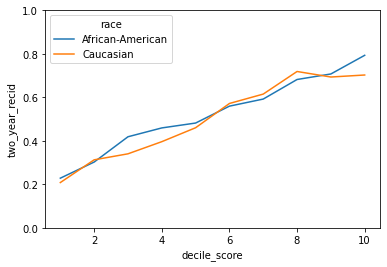

In [20]:
# calibration plot
d = pd.DataFrame(
    df.groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}))
d = d.reset_index()
im = sns.lineplot(
    data=d, x='decile_score', y='two_year_recid', hue='race');
im.set(ylim=(0,1));

We can see that for both African-American and Caucasian defendants, for any given COMPAS score, recidivism rates are similar. This is a type of fairness known as **calibration**

### Frequency of risk score by race

Next, we will look at the frequency with which defendants of each race are assigned each COMPAS score:

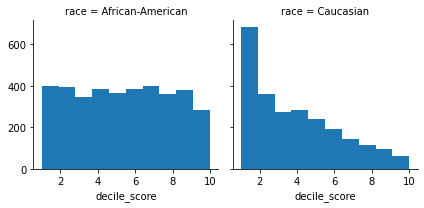

In [21]:
# frequency plot
g = sns.FacetGrid(df, col="race", margin_titles=True);
g.map(plt.hist, "decile_score", bins=10);

We observe that Caucasian defendants in this sample are more likely to be assigned a low risk score.

However, to evaluate whether this is *unfair*, we need to know the true prevalence — whether the rates of recidivism are the same in both populations, according to the data:

In [22]:
# base rates
results = df.groupby('race').agg({'two_year_recid': 'mean',  
                        'is_med_or_high_risk': 'mean', 
                        'decile_score': 'mean'})
results.round(3)

,two_year_recid,is_med_or_high_risk,decile_score
race,,,
African-American,0.514,0.588,5.369
Caucasian,0.394,0.348,3.735


The predictions of the model are pretty close to the actual prevalence in the population.

## Observations

So far, our analysis suggests that COMPAS is fair with respect to race:

* The overall accuracy of the COMPAS label is the same, regardless of race (**overall accuracy equality**)

* The likelihood of recidivism among defendants labeled as medium or high risk is similar, regardless of race (**predictive parity**)

* For any given COMPAS score, the risk of recidivism is similar, regardless of race — the “meaning” of the score is consistent across race (**calibration**)

Because the error types differ between black and white people (an error in a white person is more likely to be a false negative, whereas the error in a black person is more likely to be a false positive, we do not have **statistical parity**. However, but we can’t necessarily expect the dominant error type to be the same when the prevalence of actual positive is different between groups.

Why is it so tricky to satisfy multiple types of fairness at once? This is due to a proven *impossibility result*.

Any time:

* the *base rate* (prevalence of the positive condition) is different in the two groups, and

* we do not have a perfect classifier

Then we cannot simultaneously satisfy:

* Equal PPV and NPV for both groups (known as **conditional use accuracy equality**), and

* Equal FPR and FNR for both groups (known as **equalized odds** or **conditional procedure accuracy equality**)


## What we learned

* A model can be biased with respect to age, race, gender, if those features are not used as input to the model (due to correlations with features that are included in the model).

* There are many measures of fairness, it may be impossible to satisfy some combination of these simultaneously.

* Human biases and unfairness in society leak into the data used to train machine learning models.

## References

Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, May 2016, Machine Bias

Jeff Larson, Surya Mattu, Lauren Kirchner and Julia Angwin, May 2016, How We Analyzed the 
COMPAS Recidivism Algorithm

William Dieterich, Christina Mendoza, and Tim Brennan, July 2016, COMPAS Risk Scales: 
Demonstrating Accuracy Equity and Predictive Parity

Google’s People + AI + Research (PAIR) group explainer: Measuring fairness

Another Google Explainer: Attacking discrimination with smarter machine learning